In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [2]:
pd.set_option('display.max_rows', None)

### Import and Clean Data

In [3]:
# Import CSV data
vehicles_df = pd.read_csv('carsdataset.csv', encoding='ISO-8859-1')

In [4]:
vehicles_df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [5]:
vehicles_df.shape

(11914, 16)

In [6]:
# Find types of dataframe columns
vehicles_df.dtypes

Make                  object
Model                 object
Year                   int64
Engine Fuel Type      object
Engine HP            float64
Engine Cylinders     float64
Transmission Type     object
Driven_Wheels         object
Number of Doors      float64
Market Category       object
Vehicle Size          object
Vehicle Style         object
highway MPG            int64
city mpg               int64
Popularity             int64
MSRP                   int64
dtype: object

In [7]:
# Find percentage of rows by column that are empty
vehicles_df.isnull().mean()

Make                 0.000000
Model                0.000000
Year                 0.000000
Engine Fuel Type     0.000252
Engine HP            0.005792
Engine Cylinders     0.002518
Transmission Type    0.000000
Driven_Wheels        0.000000
Number of Doors      0.000504
Market Category      0.314084
Vehicle Size         0.000000
Vehicle Style        0.000000
highway MPG          0.000000
city mpg             0.000000
Popularity           0.000000
MSRP                 0.000000
dtype: float64

In [8]:
# Drop columns that are greater than 10% empty
new_vehicles_df = vehicles_df.loc[:, vehicles_df.isnull().mean() < 0.1]
new_vehicles_df.isnull().mean()
new_vehicles_df.shape

(11914, 15)

### Preparing the Data for Regression (finding outliers)

In [9]:
# Drop outlier rows with 0 or negative price
filtered_new_df = new_vehicles_df.loc[(new_vehicles_df['MSRP'] > 0)]
filtered_new_df.shape

(11914, 15)

Text(0.5, 0, 'Continuous Variable')

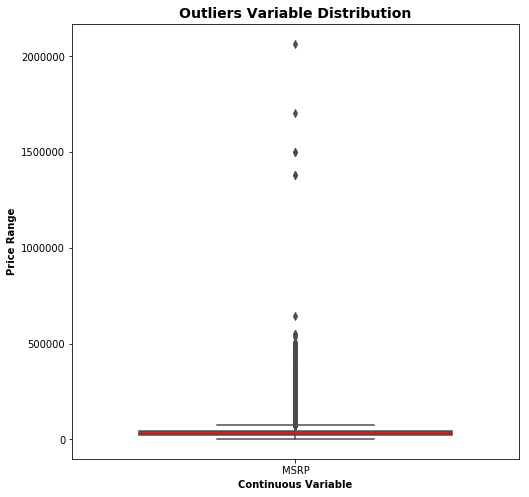

In [10]:
# Find other outliers in price
outliers = ['MSRP']
plt.rcParams['figure.figsize'] = [8,8]
sns.boxplot(data=filtered_new_df[outliers], orient="v", palette="Set1" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Price Range", fontweight = 'bold')
plt.xlabel("Continuous Variable", fontweight = 'bold')

In [11]:
# Drop the few cars that are very overpriced
final_df = filtered_new_df.loc[(filtered_new_df['MSRP'] <= 500000)]

Text(0.5, 0, 'Continuous Variable')

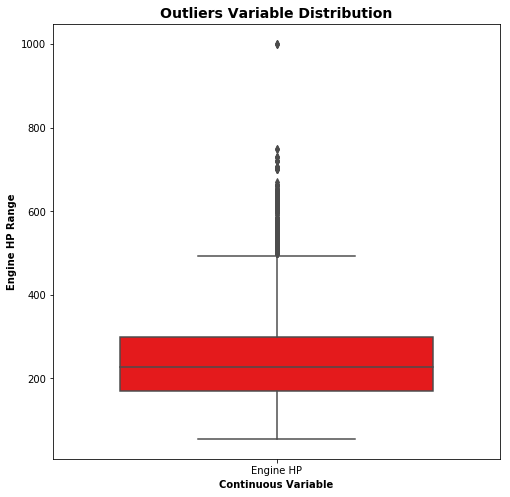

In [12]:
# Find outliers in Engine HP
outliers = ['Engine HP']
plt.rcParams['figure.figsize'] = [8,8]
sns.boxplot(data=filtered_new_df[outliers], orient="v", palette="Set1" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Engine HP Range", fontweight = 'bold')
plt.xlabel("Continuous Variable", fontweight = 'bold')

In [13]:
# Filter for cars with HP less than 800
final_df = final_df.loc[(filtered_new_df['Engine HP'] <= 800)]
final_df.shape

(11834, 15)

In [14]:
# Finally, drop any rows with null value
final_df.dropna(how='any', inplace=True)
final_df.head()
final_df.shape

(11801, 15)

### Graph Car Make Counts and Average Price

In [15]:
# Group counts by car make
make_count = final_df.groupby('Make').count()['MSRP']
make_count_df = pd.DataFrame(make_count).reset_index()
make_count_df.columns = ['Make','Count']

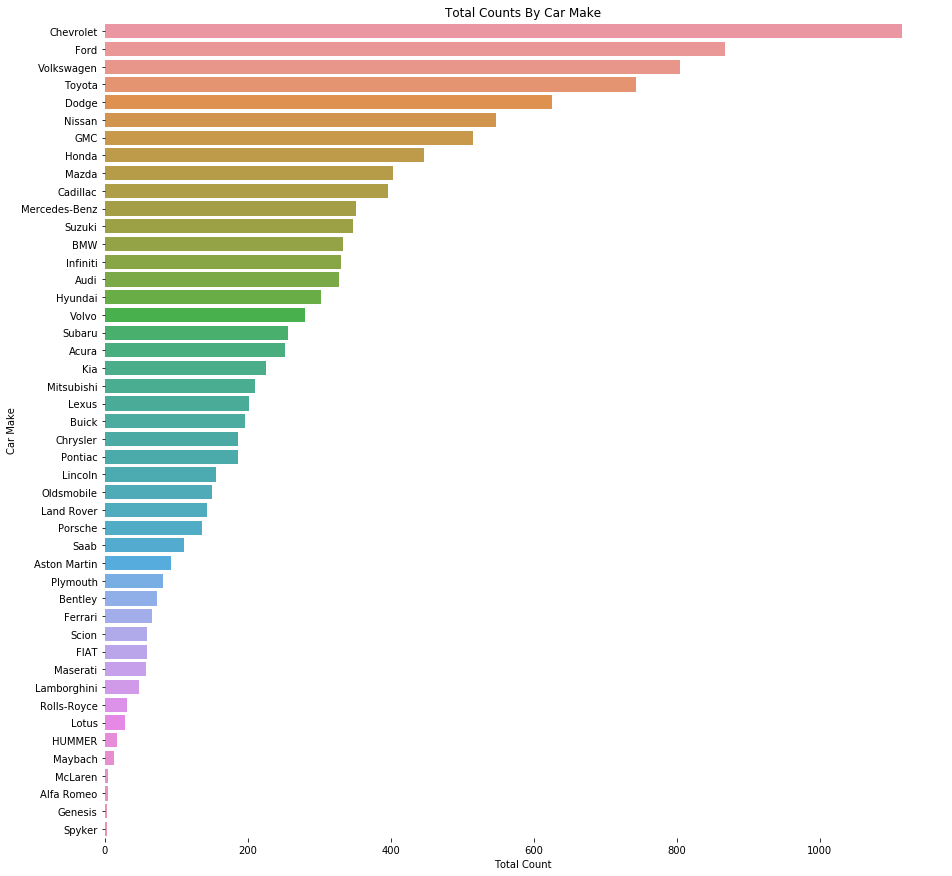

In [16]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# Plot the total counts
sns.barplot(x="Count", y="Make", data=make_count_df.sort_values('Count', ascending=False).reset_index(drop=True),
            label="Total Count")

# Add title, legend and informative axis label
ax.set(title="Total Counts By Car Make",
       ylabel="Car Make",
       xlabel="Total Count")
sns.despine(left=True, bottom=True)

In [17]:
# Avg price per car make
make_avg_price = final_df.groupby('Make').mean()['MSRP']
make_avg_price_df = pd.DataFrame(make_avg_price).reset_index()
make_avg_price_df.columns = ['Make','Avg Price']

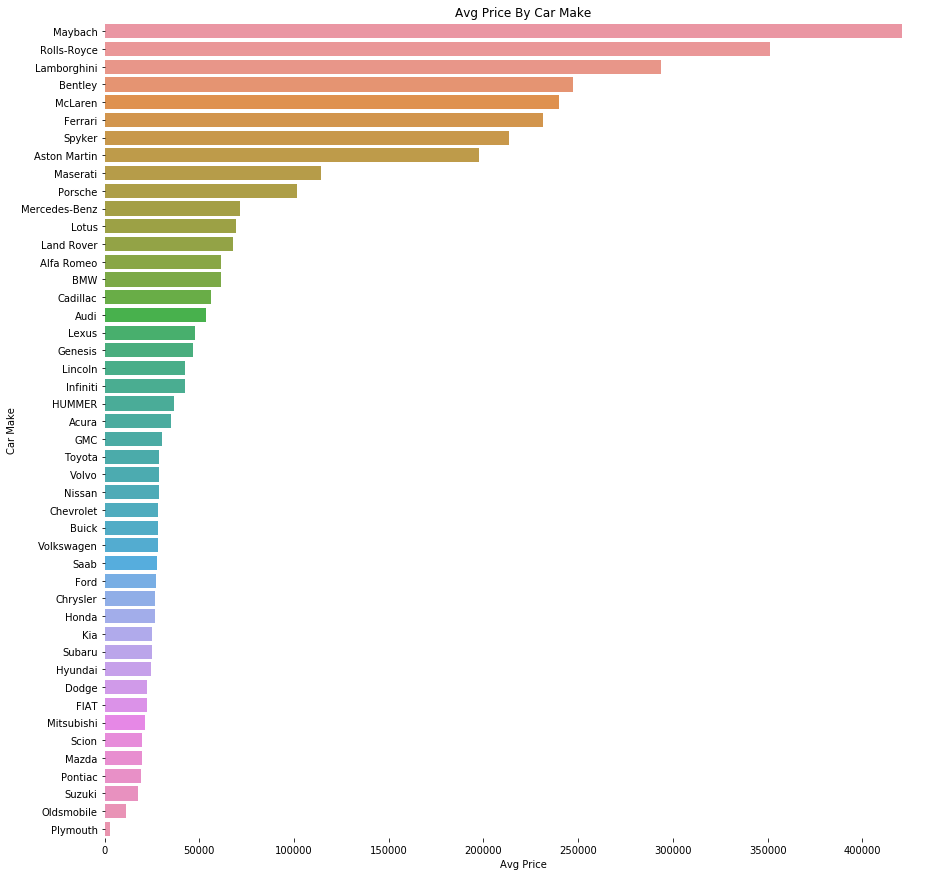

In [18]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# Plot the total counts
sns.barplot(x="Avg Price", y="Make", data=make_avg_price_df.sort_values('Avg Price', ascending=False).reset_index(drop=True),
            label="Avg Price")

# Add title, legend and informative axis label
ax.set(title="Avg Price By Car Make",
       ylabel="Car Make",
       xlabel="Avg Price")
sns.despine(left=True, bottom=True)

### Correlation Matrix

In [18]:
# Create new dataframe for correlation
correlation_df = final_df

In [19]:
# Convert categorical data into numerical data for regression 
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
categorical_columns = []
features = correlation_df.columns.values.tolist()
for col in features:
    if correlation_df[col].dtype in numerics: continue
    categorical_columns.append(col)
# Encoding categorical features
for col in categorical_columns:
    if col in correlation_df.columns:
        le = LabelEncoder()
        le.fit(list(correlation_df[col].astype(str).values))
        correlation_df[col] = le.transform(list(correlation_df[col].astype(str).values))

In [20]:
# View new dataframe
correlation_df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,4,1,2011,7,335.0,6.0,3,3,2.0,0,8,26,19,3916,46135
1,4,0,2011,7,300.0,6.0,3,3,2.0,0,6,28,19,3916,40650
2,4,0,2011,7,300.0,6.0,3,3,2.0,0,8,28,20,3916,36350
3,4,0,2011,7,230.0,6.0,3,3,2.0,0,8,28,18,3916,29450
4,4,0,2011,7,230.0,6.0,3,3,2.0,0,6,28,18,3916,34500


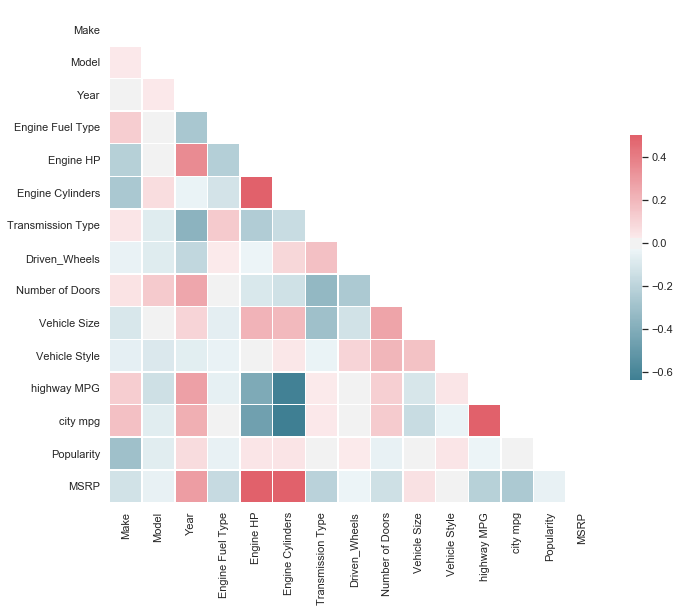

In [21]:
# Graphing the correlation matrix
sns.set(style="white")

corr = correlation_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.5, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
# LINEAR REGRESSION

In [24]:
linr_df_dummy = pd.get_dummies(test_data_df,drop_first=True)

In [26]:
linr_df = linr_df_dummy

In [27]:
target = 'MSRP'

In [28]:
X = linr_df.drop(target, axis=1)
y = linr_df['MSRP'].values.reshape(-1, 1)
print(X.shape, y.shape)

(11801, 982) (11801, 1)


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

In [33]:
model = LinearRegression()

In [34]:
model.fit(X_train, y_train)
training_score = model.score(X_train, y_train)
testing_score = model.score(X_test, y_test)

print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")

Training Score: 0.9854443196541153
Testing Score: -8317762447854.699


Text(0.5, 1.0, 'Residual Plot')

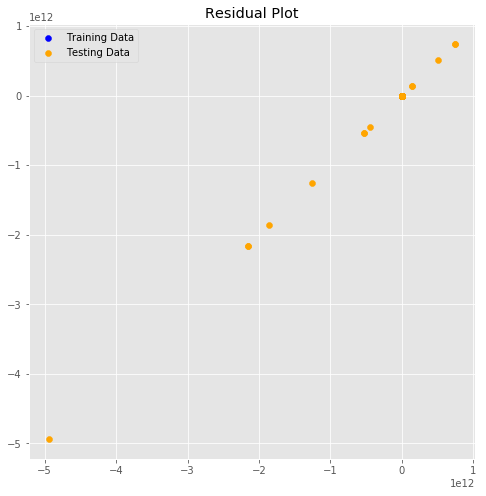

In [35]:
plt.scatter(model.predict(X_train), model.predict(X_train) - y_train, c="blue", label="Training Data")
plt.scatter(model.predict(X_test), model.predict(X_test) - y_test, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y.min(), xmax=y.max())
plt.title("Residual Plot")

### Random Forest Regression

In [23]:
# Create new dataframe for regression
test_data_df = final_df

In [24]:
# Convert categorical data into numerical data for regression 
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
categorical_columns = []
features = test_data_df.columns.values.tolist()
for col in features:
    if test_data_df[col].dtype in numerics: continue
    categorical_columns.append(col)
# Encoding categorical features
for col in categorical_columns:
    if col in test_data_df.columns:
        le = LabelEncoder()
        le.fit(list(test_data_df[col].astype(str).values))
        test_data_df[col] = le.transform(list(test_data_df[col].astype(str).values))

In [26]:
# Set the target for the prediction
target='MSRP'

# set X and y
y = test_data_df[target]
X = test_data_df.drop(target, axis=1)
feature_names = X.columns

# Split the data set into training and testing data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

In [27]:
# Fit the training and test data, run the regression
rf = RandomForestRegressor(n_estimators=200)
rf = rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.9782059082403066

No handles with labels found to put in legend.


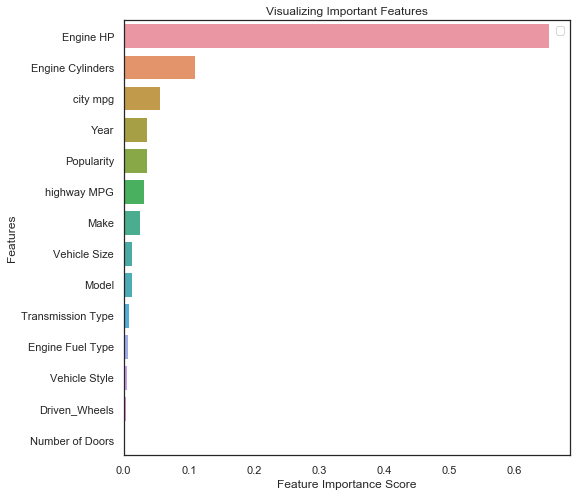

In [28]:
# Graph feature importance
feature_imp = pd.Series(rf.feature_importances_,index=X.columns).sort_values(ascending=False)

# Creating a bar plot
sns.barplot(x=feature_imp[:20], y=feature_imp.index[:20])
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

### Random Forest Regression without 'Model' and 'Make'

In [29]:
# Filter dataframe
fil_test_data_df = test_data_df.drop('Make',axis=1)
filtered_test_data_df = fil_test_data_df.drop('Model',axis=1)
filtered_test_data_df.head()

,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,2011,7,335.0,6.0,3,3,2.0,0,8,26,19,3916,46135
1,2011,7,300.0,6.0,3,3,2.0,0,6,28,19,3916,40650
2,2011,7,300.0,6.0,3,3,2.0,0,8,28,20,3916,36350
3,2011,7,230.0,6.0,3,3,2.0,0,8,28,18,3916,29450
4,2011,7,230.0,6.0,3,3,2.0,0,6,28,18,3916,34500


In [30]:
# Convert categorical data into numerical data for regression 
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
categorical_columns = []
features = filtered_test_data_df.columns.values.tolist()
for col in features:
    if filtered_test_data_df[col].dtype in numerics: continue
    categorical_columns.append(col)
# Encoding categorical features
for col in categorical_columns:
    if col in filtered_test_data_df.columns:
        le = LabelEncoder()
        le.fit(list(filtered_test_data_df[col].astype(str).values))
        test_data_df[col] = le.transform(list(test_data_df[col].astype(str).values))

In [31]:
# Set the target for the prediction
target='MSRP'

# set X and y
y = filtered_test_data_df[target]
X = filtered_test_data_df.drop(target, axis=1)
feature_names = X.columns

# Split the data set into training and testing data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

In [32]:
# Fit the training and test data, run the regression
rf = RandomForestRegressor(n_estimators=200)
rf = rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.9745779404794966

No handles with labels found to put in legend.


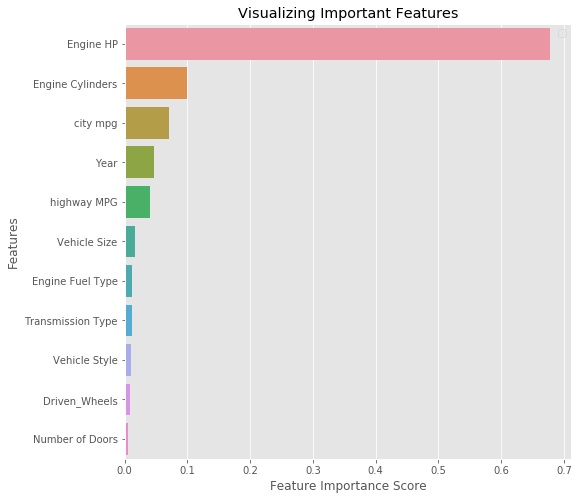

In [55]:
# Graph feature importance
feature_imp = pd.Series(rf.feature_importances_,index=X.columns).sort_values(ascending=False)

# Creating a bar plot
sns.barplot(x=feature_imp[:20], y=feature_imp.index[:20])
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()